In [2]:
import numpy as np
from os.path import join
import os
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, normalized_mutual_info_score as nmi_score, completeness_score
import umap
import sys
import importlib
import torch
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow
%matplotlib inline

# Init

In [3]:
PROJ_DIR = '/home/gcgreen2/neurips_comp'
DATA_DIR = join(PROJ_DIR, 'data')
OUT_DIR = os.getcwd()

In [4]:
sys.path.append(join(PROJ_DIR,'cae'))
from scripts import models, utils, task3_metrics as t3

In [5]:
# importlib.reload(models)

In [6]:
with open(join(OUT_DIR,'config_vae.py'), 'r') as fh:
    lines = fh.read()
    eval(compile(lines, '<string>', 'exec'))

In [7]:
par

{'out_dir': '/home/gcgreen2/neurips_comp/out/4-18-vae2',
 'data_mod1': '/home/gcgreen2/neurips_comp/data/multiome/multiome_gex_processed_training.h5ad',
 'data_mod2': '/home/gcgreen2/neurips_comp/data/multiome/multiome_atac_processed_training.h5ad',
 'model': 'VAE',
 'n_pcs': 2500,
 'h1_dim': 256,
 'h2_dim': 64,
 'z_dim': 16,
 'n_epochs': 400,
 'batch': 128,
 'lr': 0.0001,
 'lambda_mod1': 1,
 'lambda_mod2': 1,
 'lambda_kl_mod1': 0.0001,
 'lambda_kl_mod2': 1,
 'lambda_reg': 0,
 'in_dim': 2500}

## Load data & model

In [8]:
adata_mod1 = ad.read_h5ad(par['data_mod1'])
adata_mod2 = ad.read_h5ad(par['data_mod2'])

In [9]:
mod1_pca = np.load(files['mod1_pca'])
mod2_pca = np.load(files['mod2_pca'])

In [10]:
adata_mod1.obsm['X_pca'] = mod1_pca
adata_mod2.obsm['X_pca'] = mod2_pca

In [11]:
adata_mod1.obs['mod'] = 'mod1'
adata_mod2.obs['mod'] = 'mod2'

In [12]:
model_mod1, model_mod2 = eval(utils.model_str(par)), eval(utils.model_str(par))
model_path = lambda name: os.path.join(par['out_dir'], 'model_'+name+'.torch')
model_mod1.load_state_dict(torch.load(model_path('mod1')))
model_mod2.load_state_dict(torch.load(model_path('mod2')))

/home/gcgreen2/envs/py3.9venv/lib/python3.9/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


<All keys matched successfully>

## Get latent space repr. and perform clustering

In [13]:
X,Y = [torch.FloatTensor(data.obsm['X_pca']) for data in [adata_mod1,adata_mod2]]
_,Mu_mod1,Logvar_mod1,Z_mod1 = [x.detach().numpy() for x in model_mod1(X)]
_,Mu_mod2,Logvar_mod2,Z_mod2 = [x.detach().numpy() for x in model_mod2(Y)]

In [14]:
adata_mod1.obsm['Z'] = Z_mod1
adata_mod2.obsm['Z'] = Z_mod2
adata_mod1.obsm['Z_mu'] = Mu_mod1
adata_mod2.obsm['Z_mu'] = Mu_mod2
adata_mod1.obsm['Z_var'] = Logvar_mod1
adata_mod2.obsm['Z_var'] = Logvar_mod2
# adata_mod1.obsm['Z_2d'] = Z_mod1[:,:2]
# adata_mod2.obsm['Z_2d'] = Z_mod2[:,:2]

adata_mod1.obsm['Z_mu_avg'] = 1/2 * (Mu_mod1+Mu_mod2)

In [15]:
overwrite = False
umap_path = join(OUT_DIR, 'umap_mod1.npy')
if os.path.exists(umap_path) and not overwrite:
    Z_umap_mod1 = np.load(umap_path, allow_pickle=True)
else:
    Z_umap_mod1 = umap.UMAP().fit_transform(Z_mod1)
    np.save(umap_path, Z_umap_mod1)

In [16]:
overwrite = False
umap_path = join(OUT_DIR, 'umap_mod2.npy')
if os.path.exists(umap_path) and not overwrite:
    Z_umap_mod2 = np.load(umap_path, allow_pickle=True)
else:
    Z_umap_mod2 = umap.UMAP().fit_transform(Z_mod2)
    np.save(umap_path, Z_umap_mod2)

In [17]:
adata_mod1.obsm['Z_umap'] = Z_umap_mod1
adata_mod2.obsm['Z_umap'] = Z_umap_mod2

In [18]:
# tsne_path = join(OUT_DIR, 'tsne.npy')
# if os.path.exists(tsne_path):
#     Z_tsne = np.load(tsne_path, allow_pickle=True)
# else:
#     Z = np.concatenate((Z_mod1,Z_mod2), axis=0)
#     Z_tsne = TSNE(2).fit_transform(Z)
#     np.save(tsne_path, Z_tsne)

In [19]:
# adata_mod1.obsm['Z_tsne'] = Z_tsne[:len(Z_tsne)//2]
# adata_mod2.obsm['Z_tsne'] = Z_tsne[len(Z_tsne)//2:]

## Add test and train info

In [20]:
# idx_train = np.loadtxt(files['idx_train'], dtype=int)
# idx_test = np.loadtxt(files['idx_test'], dtype=int)

In [21]:
# is_train = np.full(len(adata_mod1), True)
# is_train[idx_test] = False

In [22]:
# adata_mod1.obs['is_train'] = is_train
# adata_mod2.obs['is_train'] = is_train

In [23]:
# mod1_train, mod2_train, mod1_test, mod2_test = \
#     [adata[idx] for idx in [idx_train, idx_test] for adata in [adata_mod1,adata_mod2]]

# Latent space plots

In [24]:
# names=['Mu_mod1','Mu_mod2','Logvar_mod1','Logvar_mod2','Z_mod1','Z_mod2']
# xs=[Mu_mod1,Mu_mod2,np.exp(0.5*Logvar_mod1),np.exp(0.5*Logvar_mod2),Z_mod1,Z_mod2]
# plt.figure(figsize=(10,7))
# for x,n in zip(xs,names):
#     plt.hist(x.flatten(),alpha=0.5,label=n)
# plt.legend()

In [25]:
def plot_latent(mod, col, train_test='all', clustering='Z_umap'):
#     if train_test != 'all':
#         idx = np.where(mod1.obs['is_train'] == (train_test=='train'))
#         mod1 = mod1[idx]
#         mod2 = mod2[idx]
        
    labels = set(np.unique(mod.obs[col]))
    colors = rainbow(np.linspace(0,1,len(labels),endpoint=False), alpha=0.2)
    
    plt.figure(figsize=(9,7))
    plt.title(col + ', latent space tsne')
    for i,label in enumerate(labels):
        cur_mod = mod[np.where(mod.obs[col] == label)].obsm[clustering]
        x = cur_mod[:,0]
        y = cur_mod[:,1]
        plt.plot(x, y, 'o', color=colors[i], label=label)
        
    leg = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    for lh in leg.legendHandles: 
        lh._legmarker.set_alpha(1)

### Modality

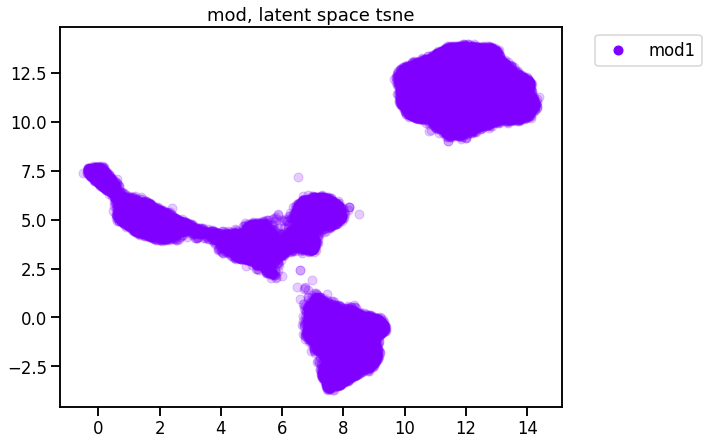

In [26]:
plot_latent(adata_mod1, 'mod')

### Cell type

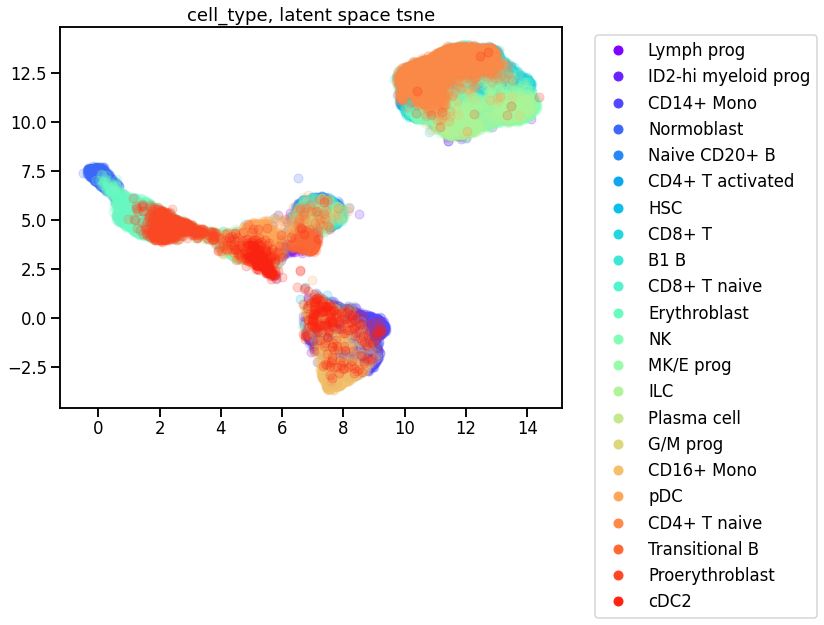

In [27]:
plot_latent(adata_mod1, 'cell_type')

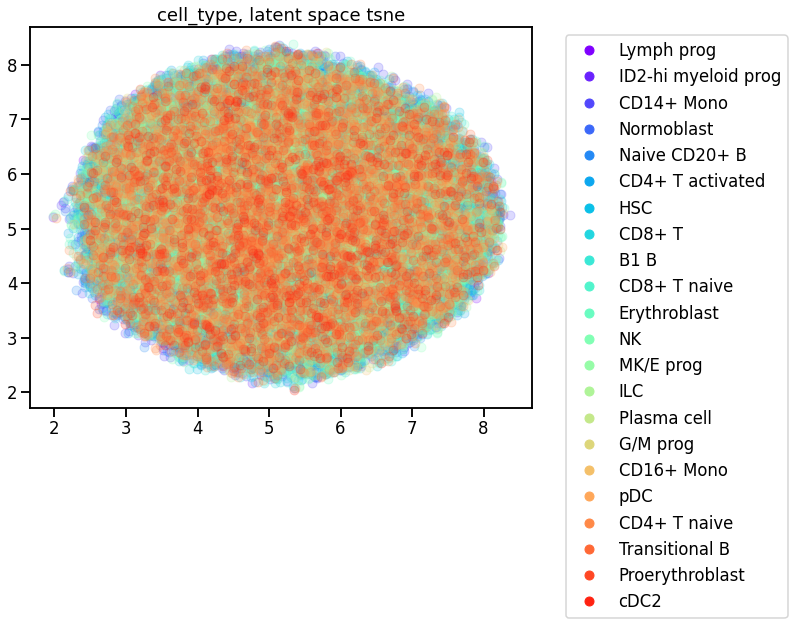

In [28]:
plot_latent(adata_mod2, 'cell_type')

### Batch

In [29]:
plot_latent(adata_mod1, adata_mod2, 'batch')

TypeError: 'AnnData object with n_obs × n_vars = 42492 × 116490
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'cell_type', 'pseudotime_order_ATAC', 'batch', 'pseudotime_order_GEX', 'is_train', 'mod'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism', 'sample_pm_varnames'
    obsm: 'gene_activity', 'lsi_full', 'lsi_red', 'umap', 'X_pca', 'Z', 'Z_mu', 'Z_var', 'Z_umap'
    layers: 'counts'' is an invalid key

# Clustering metrics

In [ ]:
clust_path = join(OUT_DIR, 'clustering.npy')
sc.pp.neighbors(adata_mod1, n_pcs=0, use_rep='Z_mu_avg')
sc.tl.louvain(adata_mod1)
np.save(clust_path, adata_mod1.obs['louvain'])

In [ ]:
pred = adata_mod1.obs['louvain']
gt = adata_mod1.obs['cell_type']

In [ ]:
silhouette = silhouette_score(adata_mod1.obsm['Z_mu_avg'], gt)
nmi = nmi_score(gt, pred)
completeness = completeness_score(gt, pred)
print(f'silhouette coef: {silhouette},  nmi: {nmi},  completeness: {completeness}')

# Task 3 Metrics

In [ ]:
adata_mod1

In [ ]:
t3.evaluation_task3()